In [1]:
def draw_bbox2d_from_kitti(image, label, color=(255, 0, 0)):
    if not label:
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image, 'No label found!', (200, 200), font, 4, color, 2, cv2.LINE_AA)
        return image
    #x = tuple((label['xleft'], label['ytop']))
    #y = tuple((label['xright'], label['ybottom']))
    x = tuple((label['xleft'], label['ytop']))
    y = tuple((label['xright'], label['ybottom']))
    cv2.rectangle(image, x, y, color, 2)

    return image

In [2]:
def draw_bbox3d(img, box3d):
    # Different colors for 3D bounding box: ground (lengthwise and crosswise), height, and top
    color_bbox3d = [(255, 20, 20),
                    (20, 20, 255),
                    (255, 20, 20),
                    (20, 20, 255)]

    for index in range(4):
        img = cv2.line(img, tuple(box3d[index]), tuple(box3d[(index + 1) % 4]), color_bbox3d[index], 1)
        img = cv2.line(img, tuple(box3d[index + 4]), tuple(box3d[(index + 1) % 4 + 4]), (20, 20, 255), 1)
        img = cv2.line(img, tuple(box3d[index]), tuple(box3d[index + 4]), (20, 255, 20), 1)

    # Draw the 3 axes
    img = cv2.line(img, tuple(box3d[0]), tuple(box3d[1]), (255, 0, 0), 2)
    img = cv2.line(img, tuple(box3d[0]), tuple(box3d[3]), (0, 0, 255), 2)
    img = cv2.line(img, tuple(box3d[0]), tuple(box3d[4]), (0, 255, 0), 2)
    return img

In [3]:
import numpy as np
import os
import json
from pyquaternion import Quaternion
import cv2

def read_label(file, label_dir):
    """Read label file and return object list"""
    file_name = file.split('.png')[0]
    print(file_name)
    object_list = get_kitti_object_list(os.path.join(label_dir, file_name + '.txt'), camera_to_velodyne=camera_to_velodyne)
    return object_list


def get_kitti_object_list(label_file, camera_to_velodyne=None):
    """Create dict for all objects of the label file, objects are labeled w.r.t KITTI definition"""
    kitti_object_list = []

    try:
        with open(label_file.replace('.png', '.txt'), 'r') as file:
            for line in file:
                line = line.replace('\n', '')  # remove '\n'
                kitti_properties = line.split(' ')

                object_dict = {
                    'identity':     kitti_properties[0],
                    'truncated':    float(kitti_properties[1]),
                    'occlusion':    float(kitti_properties[2]),
                    'angle':        float(kitti_properties[3]),
                    'xleft':        int(round(float(kitti_properties[4]))),
                    'ytop':         int(round(float(kitti_properties[5]))),
                    'xright':       int(round(float(kitti_properties[6]))),
                    'ybottom':      int(round(float(kitti_properties[7]))),
                    'height':       float(kitti_properties[8]),
                    'width':        float(kitti_properties[9]),
                    'length':       float(kitti_properties[10]),
                    'posx':         float(kitti_properties[11]),
                    'posy':         float(kitti_properties[12]),
                    'posz':         float(kitti_properties[13]),
                    'orient3d':     float(kitti_properties[14]),
                    'rotx':         float(kitti_properties[15]),
                    'roty':         float(kitti_properties[16]),
                    'rotz':         float(kitti_properties[17]),
                    'score':        float(kitti_properties[18]),
                    'qx':           float(kitti_properties[19]),
                    'qy':           float(kitti_properties[20]),
                    'qz':           float(kitti_properties[21]),
                    'qw':           float(kitti_properties[22]),
                    'visibleRGB':   bool(kitti_properties[23]),
                    'visibleGated': bool(kitti_properties[24]),
                    'visibleLidar': bool(kitti_properties[25]),
                }

                kitti_object_list.append(object_dict)

            return kitti_object_list

    except:
        print('Problem occurred when reading label file!')
        return []


def load_calib_data(path_total_dataset, name_camera_calib, tf_tree):
    """
    :param path_total_dataset: Path to dataset root dir
    :param name_camera_calib: Camera calib file containing image intrinsic
    :param tf_tree: TF (transformation) tree containing translations from velodyne to cameras
    :return:
    """

    with open(os.path.join(path_total_dataset, name_camera_calib), 'r') as f:
        data_camera = json.load(f)

    with open(os.path.join(path_total_dataset, tf_tree), 'r') as f:
        data_extrinsics = json.load(f)

    # Scan data extrinsics for transformation from lidar to camera
    important_translations = ['lidar_hdl64_s3_roof', 'radar_ars300', 'cam_stereo_left_optical']
    translations = []

    for item in data_extrinsics:
        if item['child_frame_id'] in important_translations:
            translations.append(item)
            if item['child_frame_id'] == 'cam_stereo_left_optical':
                T_cam = item['transform']
            elif item['child_frame_id'] == 'lidar_hdl64_s3_roof':
                T_velodyne = item['transform']
            elif item['child_frame_id'] == 'radar_ars300':
                T_radar = item['transform']

    # Use pyquaternion to setup rotation matrices properly
    R_c_quaternion = Quaternion(w=T_cam['rotation']['w'] * 360 / 2 / np.pi, x=T_cam['rotation']['x'] * 360 / 2 / np.pi,
                     y=T_cam['rotation']['y'] * 360 / 2 / np.pi, z=T_cam['rotation']['z'] * 360 / 2 / np.pi)
    R_v_quaternion = Quaternion(w=T_velodyne['rotation']['w'] * 360 / 2 / np.pi, x=T_velodyne['rotation']['x'] * 360 / 2 / np.pi,
                     y=T_velodyne['rotation']['y'] * 360 / 2 / np.pi, z=T_velodyne['rotation']['z'] * 360 / 2 / np.pi)

    # Setup quaternion values as 3x3 orthogonal rotation matrices
    R_c_matrix = R_c_quaternion.rotation_matrix
    R_v_matrix = R_v_quaternion.rotation_matrix

    # Setup translation Vectors
    Tr_cam = np.asarray([T_cam['translation']['x'], T_cam['translation']['y'], T_cam['translation']['z']])
    Tr_velodyne = np.asarray([T_velodyne['translation']['x'], T_velodyne['translation']['y'], T_velodyne['translation']['z']])
    Tr_radar = np.asarray([T_radar['translation']['x'], T_radar['translation']['y'], T_radar['translation']['z']])

    # Setup Translation Matrix camera to lidar -> ROS spans transformation from its children to its parents
    # Therefore one inversion step is needed for zero_to_camera -> <parent_child>
    zero_to_camera = np.zeros((3, 4))
    zero_to_camera[0:3, 0:3] = R_c_matrix
    zero_to_camera[0:3, 3] = Tr_cam
    zero_to_camera = np.vstack((zero_to_camera, np.array([0, 0, 0, 1])))

    zero_to_velodyne = np.zeros((3, 4))
    zero_to_velodyne[0:3, 0:3] = R_v_matrix
    zero_to_velodyne[0:3, 3] = Tr_velodyne
    zero_to_velodyne = np.vstack((zero_to_velodyne, np.array([0, 0, 0, 1])))

    zero_to_radar = zero_to_velodyne.copy()
    zero_to_radar[0:3, 3] = Tr_radar

    # Calculate total extrinsic transformation to camera
    velodyne_to_camera = np.matmul(np.linalg.inv(zero_to_camera), zero_to_velodyne)
    camera_to_velodyne = np.matmul(np.linalg.inv(zero_to_velodyne), zero_to_camera)
    radar_to_camera = np.matmul(np.linalg.inv(zero_to_camera), zero_to_radar)

    # Read projection matrix P and camera rectification matrix R
    P = np.reshape(data_camera['P'], [3, 4])

    # In our case rectification matrix R has to be equal to the identity as the projection matrix P contains the
    # R matrix w.r.t KITTI definition
    R = np.identity(4)

    # Calculate total transformation matrix from velodyne to camera
    vtc = np.matmul(np.matmul(P, R), velodyne_to_camera)

    return velodyne_to_camera, camera_to_velodyne, P, R, vtc, radar_to_camera, zero_to_camera

def load_velodyne_scan(file):
    """Load and parse velodyne binary file"""
    scan = np.fromfile(file, dtype=np.float32)
    return scan.reshape((-1, 5)[:, :4])

def project_3d_to_2d(points3d, P):
    points2d = np.matmul(P, np.vstack((points3d, np.ones([1, np.shape(points3d)[1]]))))

    # scale projected points
    points2d[0][:] = points2d[0][:] / points2d[2][:]
    points2d[1][:] = points2d[1][:] / points2d[2][:]

    points2d = points2d[0:2]
    return points2d.transpose()

def project_points_to_2d(points3d, P):
    points2d = np.dot(P[:3, :3], points3d.T).T + P[:3, 3]
    points2d = points2d[:, :2] / points2d[:, 2][:, np.newaxis]
    points2d = points2d.astype(np.int32)
    return points2d



## Velodyne to Camera (vtc) Transformation Matrix 

In [4]:
path_total_dataset = "/Users/apple/Downloads"
name_camera_calib = "calib_cam_stereo_left.json"
tf_tree = "calib_tf_tree_full.json"
scan_path = "/Users/apple/Documents/SeeingThroughFog/tools/DatasetFoggification/example_data/LidarData/2019-09-11_19-13-44_00960.bin"

#scan = load_velodyne_scan(scan_path)
velodyne_to_camera, camera_to_velodyne, P, R, vtc, radar_to_camera, zero_to_camera = load_calib_data(path_total_dataset, name_camera_calib, tf_tree) 



In [5]:
file = "2019-09-11_19-13-44_00960"
label_dir = "/Users/apple/Downloads/cam_left_labels_TMP"
label = read_label(file, label_dir)

2019-09-11_19-13-44_00960


In [6]:
# Open the training data setFoggification/example_data/LidarData/2019-09-11_19-13-44_00960
filename = "/Users/apple/Downloads/cam_left_labels_TMP/2019-09-11_19-13-44_00960.txt"
with open(filename) as f:
    records = f.readlines()
#print(records)

In [7]:
from matplotlib import pyplot as plt
import cv2
%matplotlib inline
test_image = cv2.imread("/Users/apple/Documents/SeeingThroughFog/SeeingThroughFogData/cam_stereo_left_lut/2019-09-11_19-13-44_00960.png")
cv2.imshow("test", test_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

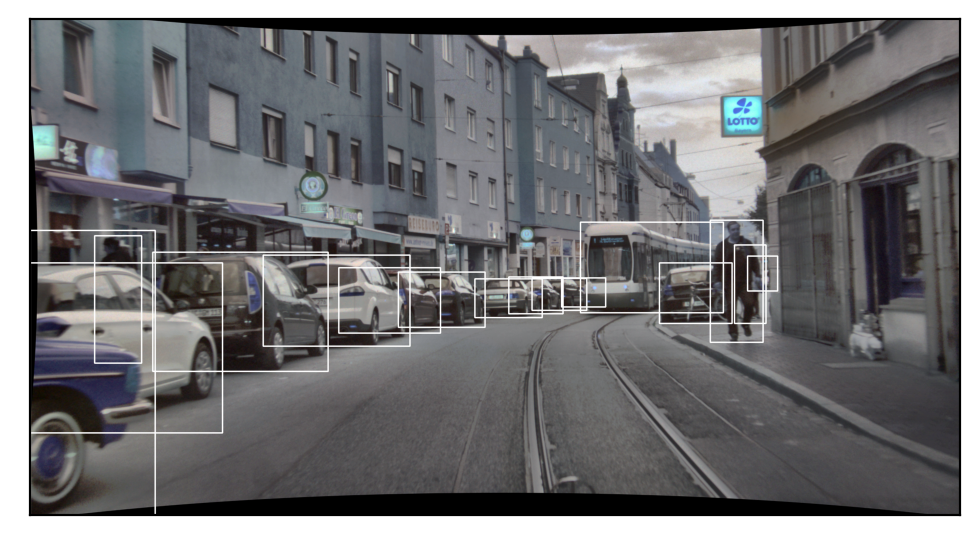

In [8]:
for record in range(0,len(records)):
    image = draw_bbox2d_from_kitti(test_image, label=label[record], color=(255, 255, 255))
plt.figure(dpi=200)
plt.imshow(image)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

In [9]:
def load_velodyne_scan(file):
    """Load and parse velodyne binary file"""
    scan = np.fromfile(file, dtype=np.float32)
    return scan.reshape((-1, 5))[:, :4]

In [10]:
import sys
import os
# sys.path.append('/scratch/fs2/Software/AdverseWeatherLabeling/lib')
# sys.path.append('/scratch/fs2/Software/frameworks/dense_label_tools')
# sys.path.append('/scratch/fs2/Software/frameworks/dense_label_tools/lib')

#import pyqtgraph.opengl as gl
import matplotlib as mpl
import matplotlib.cm as cm
import argparse
from PyQt5 import QtGui, QtCore, uic
import json
import numpy as np
import cv2
from datetime import datetime

## Load Velodyne Data

In [11]:
file_lidar = "/Users/apple/Documents/SeeingThroughFog/tools/DatasetFoggification/example_data/LidarData/2019-09-11_19-13-44_00960.bin"
pointcloud = load_velodyne_scan(file_lidar)
print(pointcloud.shape)

(109431, 4)


In [12]:
vtc

array([[ 1.00731561e+03, -2.34756217e+03, -1.06708356e+01,
        -4.81188770e+02],
       [ 4.91165653e+02,  7.62879023e+00, -2.35928902e+03,
        -1.33431015e+03],
       [ 9.99941060e-01,  8.17631422e-03, -7.14315138e-03,
        -6.95557798e-01]])

In [13]:
velodyne_to_camera

array([[ 0.00816556, -0.99996549, -0.00153346,  0.08749686],
       [-0.00715544,  0.00147505, -0.99997331, -0.41640329],
       [ 0.99994106,  0.00817631, -0.00714315, -0.6955578 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [14]:
pointcloud

array([[  5.888751  ,   4.646016  ,  -0.7410531 , 119.85      ],
       [  5.8201113 ,   4.8816843 ,  -0.71615297, 241.        ],
       [  8.671461  ,   8.971026  ,   0.2508448 , 133.        ],
       ...,
       [  4.8374286 ,   5.086774  ,  -0.9520405 , 228.9       ],
       [  5.0420184 ,   4.5974975 ,  -1.3696643 , 238.        ],
       [  4.8705215 ,   4.908844  ,  -1.3168626 ,  95.4       ]],
      dtype=float32)

## Project 3D to 2D

In [15]:
ps = project_3d_to_2d(pointcloud[:,:3].transpose(), vtc)

In [16]:
import matplotlib as mpl
import matplotlib.cm as cm

In [17]:
ps

array([[-1040.51373815,   638.22823647],
       [-1174.43086907,   628.94770747],
       [-1591.78435269,   298.4281365 ],
       ...,
       [-1799.46806066,   793.94540873],
       [-1406.74347999,  1003.44271348],
       [-1677.18577516,   994.79459899]])

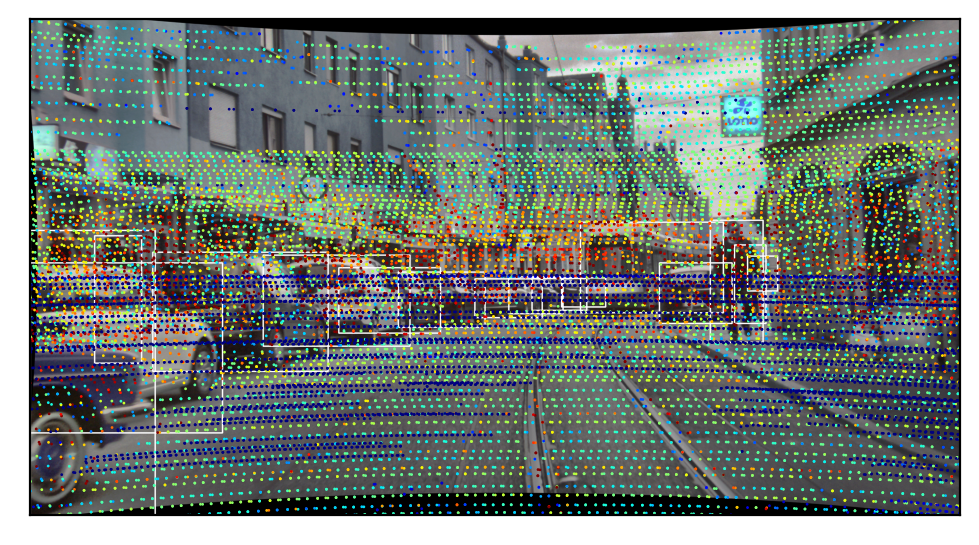

In [18]:
# Reflectance or Pulse Intensity

from scipy import ndimage
r_lidar = pointcloud[:, 3]
pixel_values = r_lidar
plt.figure(dpi=200)
plt.scatter(ps[:, 0], ps[:, 1], s=1, c=pixel_values, linewidths=0, alpha=1, cmap="jet")
plt.imshow(test_image)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

<ipython-input-19-2eea0be41d03>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


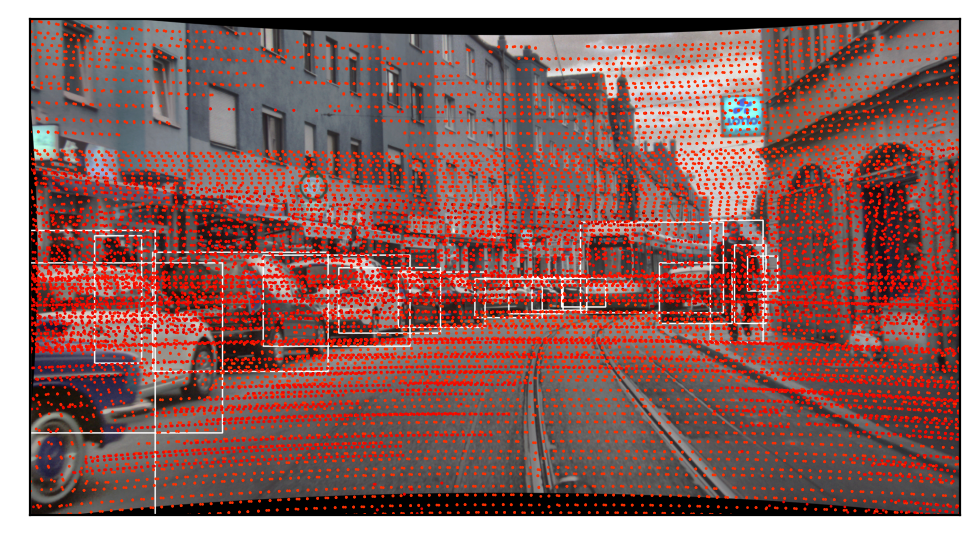

In [19]:
# Height

z_lidar = pointcloud[:, 2]
pixel_values = z_lidar
fig, ax = plt.subplots(dpi=200)
#ax.figure(dpi=200)
ax.scatter(ps[:, 0], ps[:, 1], s=1, c=pixel_values, linewidths=0, alpha=1, cmap="jet")
ax.imshow(test_image)
ax.xaxis.set_visible(False)    # Do not draw axis tick marks
ax.yaxis.set_visible(False) 
#ax.gca().axes.get_yaxis().set_visible(False)
#ax.gca().axes.get_xaxis().set_visible(False)
ax.set_facecolor((0, 0, 0)) # Set regions with no points to black
#plt.axis('scaled')        
fig.show()

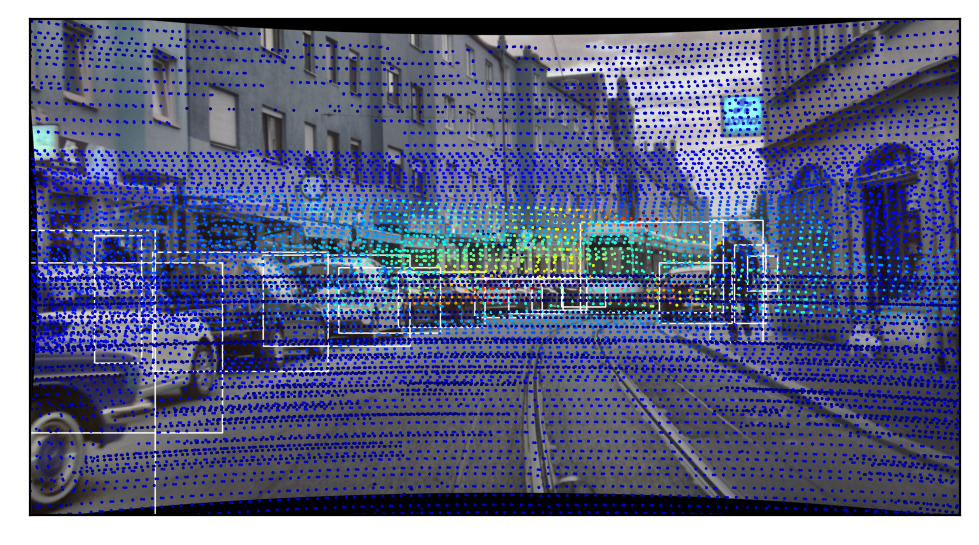

In [21]:
# Depth

x_lidar = pointcloud[:, 0]
y_lidar = pointcloud[:, 1]
d_lidar = np.sqrt(x_lidar ** 2 + y_lidar ** 2)
pixel_values = d_lidar
plt.figure(dpi=200)
plt.scatter(ps[:, 0], ps[:, 1], s=1, c=pixel_values, linewidths=0, alpha=1, cmap="jet")
plt.imshow(test_image)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()


<ipython-input-22-373b1e4d6b2e>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


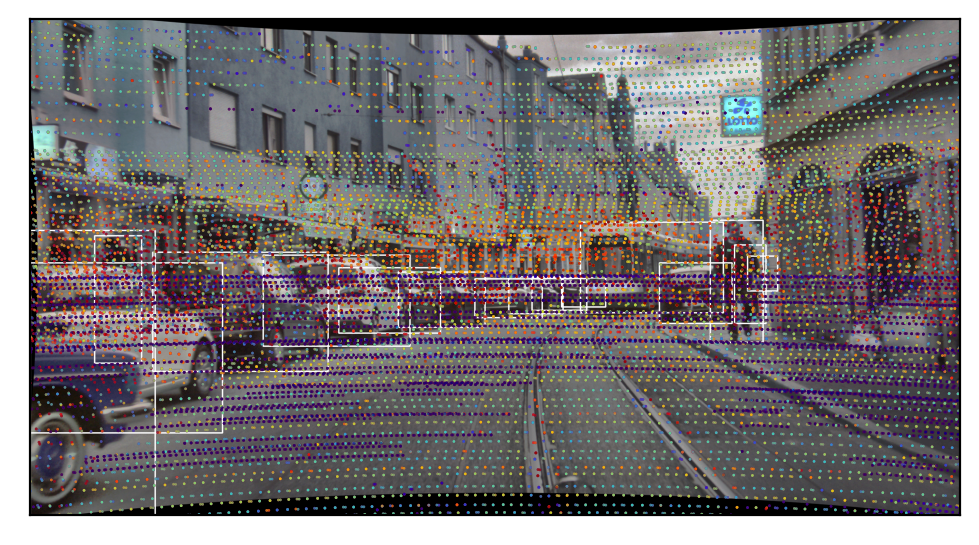

In [22]:
# Combined

from scipy import ndimage
fig = plt.figure(dpi=200)
ax = plt.gca()

d_lidar = np.sqrt(x_lidar ** 2 + y_lidar ** 2)
pixel_values = d_lidar
#plt.figure(dpi=200)
ax.scatter(ps[:, 0], ps[:, 1], s=1, c=pixel_values, linewidths=0, alpha=0.5, cmap="jet")

z_lidar = pointcloud[:, 2]
pixel_values = z_lidar
#fig, ax = plt.subplots(dpi=200)
#plt.figure(dpi=200)
ax.scatter(ps[:, 0], ps[:, 1], s=1, c=pixel_values, linewidths=0, alpha=0.5, cmap="jet")


r_lidar = pointcloud[:, 3]
pixel_values = r_lidar
#ax.figure(dpi=200)
ax.scatter(ps[:, 0], ps[:, 1], s=1, c=pixel_values, linewidths=0, alpha=0.5, cmap="jet")
ax.imshow(test_image)
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
fig.show()
